In [37]:
def orientation_percent(angles, want_ratio=False, dtheta=60):
    """Returns either a ratio or percentage
    
    angles: [array] of floats or ints
    want_ratio: [bool] Default False
    dtheta : [float] or [int]
    """
    is_oriented = np.abs(angles) <= dtheta
    n_oriented_angles = np.sum(is_oriented)
    
    ratio_oriented = n_oriented_angles/len(angles)
    
    if want_ratio:
        return ratio_oriented
    else:
        return ratio_oriented*100


def sample_proportion_error(p, n):
    """Returns the error for a sample proportion
    
    p: [float] 
        Proportion
    n: [int]
        Number of datapoints
    """
    return np.sqrt(p*(1-p) / n)

## Hypothesis test: difference between two proportions
## http://stattrek.com/hypothesis-test/difference-in-proportions.aspx

def pooled_sample_proportion(p1, p2, n1, n2):
    """Returns the pooled sample proportion between two proportions
    
    p1: [float] or [int]
        First proportion
    p2: [float] or [int]
        Second proportion
    n1: [int]
        Sample size associated with p1
    n2: [int]
        Sample size associated with p2
    """
    return (p1*n1 + p2*n2) / (n1 + n2)

def standard_error_between_two_proportions(p, n1, n2):
    """Returns the standard error between two proportions
    
    p: [float] or [int]
        Pooled sample proportion
    n1: [int]
        Sample size in first experiment
    n2: [int]
        Sample size in second experiment
    """
    return np.sqrt(p * (1 - p) * (1./n1 + 1./n2) )

def z_score_between_two_proportions(p1, p2, SE):
    """Returns the z-score between two proportions
    
    p1: [float] or [int]
        First proportion
    p2: [float] or [int]
        Second proportion
    SE: [float] or [int]
        Standard error between two proportions
    """
    return (p1 - p2) / SE



def plot_barchart(wild_orientation_percent, mutant_orientation_percent,
                            wild_errors, mutant_errors, wild_n, mutant_n, colors,
                            experiment, orientation_angle, plots_dir, times, ax):
    
    n_groups = len(times) # 3
    index = np.arange(n_groups)
    bar_width = 0.4

    kwargs = {'alpha': 0.75,
              'capsize': 5,
              'edgecolor': 'k',
              'linewidth': 1
             }
    
    def autolabel(rects):
        """ Attach a text label on each bar displaying its height
    
         Shamelessly adapted from
         https://matplotlib.org/examples/api/barchart_demo.html
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 0.7*height,
                    '{}'.format(int(height)),
                    ha = 'center', va = 'bottom',
                    size = 15)
    
    rects_wild = ax.bar(index, wild_orientation_percent,
                        bar_width,
                        color = colors['Wild Type'],
                        label = 'Wild Type',
                        yerr = wild_errors,
                        **kwargs
                       )

    rects_mutant = ax.bar(index + bar_width, mutant_orientation_percent,
                          bar_width,
                          color = colors['Mutant DEE/DEE'],
                          label ='Mutant DEE/DEE',
                          yerr = mutant_errors,
                          **kwargs
                         )

    autolabel(rects_wild)
    autolabel(rects_mutant)
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Orientation %")
    ax.set_title("Golgi Polarization {} with {} deg".format(
        experiment, orientation_angle))
    ax.set_xticks(index + bar_width/2)
    ax.set_xticklabels(tuple(times))
    ax.set_ylim([0, 100])
    ax.legend(fontsize = 15)
    
    return None

def plot_table(wild_orientation_percent, wild_errors, mutant_orientation_percent, mutant_errors,
              wild_n, mutant_n, ax):
    
    table_columns = ('2 hrs', '4 hrs', '6 hrs', '2 hrs', '4 hrs', '6 hrs')
    rows = ['N', r'Oriented [%]', r'std err [%]']
    
    table_data = [wild_n + mutant_n,
                  [int(x) for x in wild_orientation_percent + mutant_orientation_percent],
                  [int(x) for x in wild_errors + mutant_errors]]
    ## We can cast the percentages above to ints since the errors are around 3% minimum
    
    table = ax.table(cellText = table_data,
                        colWidths = [0.1]*6,
                        colLabels = table_columns,
                        rowLabels = rows,
                        loc='center'
                       )
    
    table.set_fontsize(17)
    table.scale(1.5, 1.5)
    ax.axis('off')
    
    return None

def make_and_save_barchart_with_table(wild_orientation_percent, mutant_orientation_percent,
                            wild_errors, mutant_errors, wild_n, mutant_n, colors,
                            experiment, orientation_angle, plots_dir, times):
    plt.close('all')
    fig, axes = plt.subplots(2,1, figsize=(12,12))
    
    plot_table(wild_orientation_percent, wild_errors, mutant_orientation_percent, mutant_errors,
              wild_n, mutant_n, axes[0])
    
    
    plot_barchart(wild_orientation_percent, mutant_orientation_percent,
                            wild_errors, mutant_errors, wild_n, mutant_n, colors,
                            experiment, orientation_angle, plots_dir, times, axes[1])
    
    plt.savefig('{}{}_{}deg.png'.format(plots_dir, experiment, orientation_angle))
    plt.close(fig)
    return None

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rc('axes', titlesize = 22)
plt.rc('axes', labelsize = 22)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

from glob import glob
import os
import statsmodels.api as sm

exp_names = ['exp 1', 'exp 3']

unblinding_key = {'exp 1': {'Wild Type':'Animal 1',
                            'Mutant DEE/DEE':'Animal 2'}
                  ,
                  'exp 3': {'Wild Type':'Animal 2',
                            'Mutant DEE/DEE':'Animal 1'}
                 }

times = ['2hrs', '4hrs', '6hrs']

colors = {'Wild Type': 'purple', 
          'Mutant DEE/DEE': 'blue'}

csv_dir = r'./csvfiles/'

plots_dir = r'./plots/'

orientation_angle_list = np.arange(35, 65, 5)

all_p_value_list = []
all_times_list = []
all_orientation_list = []
all_exp_list = []

## Loop over multiple experiments
for experiment in exp_names:
    csv_files = glob(os.path.join(csv_dir, experiment, "data*.csv"))
    df_in_each_file = (pd.read_csv(f) for f in csv_files)
    df = pd.concat(df_in_each_file, ignore_index=True)
    
    df['animal_id'] = df.fileID.str.split('_', expand=True).get(0)
    df['time'] = df.fileID.str.split('_', expand=True).get(1).str.lower()
    
    new_df = df.filter(['golgiAreaInSquareMicrons',
                   'anglesInDeg',
                   'nucleiAreaInSquareMicrons',
                   'time',
                   'animal_id'],
                   axis=1
                      )
    
    ## area cut - keep data with golgi area between (10, 100) microns^2
    area_above_10_microns_squared = new_df['golgiAreaInSquareMicrons'] > 10
    area_below_100_microns_squared = new_df['golgiAreaInSquareMicrons'] < 100

    golgi_area_cut = area_above_10_microns_squared & area_below_100_microns_squared
    
    ## Split into wild type and mutant dataframes
    is_wild_type = new_df.animal_id == unblinding_key[experiment]['Wild Type']
    is_mutant = new_df.animal_id == unblinding_key[experiment]['Mutant DEE/DEE']

    wild_type = new_df[golgi_area_cut & is_wild_type]
    mutant = new_df[golgi_area_cut & is_mutant]
    
    angle_bins = np.arange(-180, 180, 30)
    
    for orientation_angle in orientation_angle_list:
        
        wild_oriented_percent = orientation_percent(
            wild_type['anglesInDeg'],
            dtheta = orientation_angle)
        
        mutant_oriented_percent = orientation_percent(
            mutant['anglesInDeg'],
            dtheta = orientation_angle)
        
        wild_n = []
        mutant_n = []

        wild_orientation_percent = []
        mutant_orientation_percent = []

        wild_errors = []
        mutant_errors = []

        pvalues = []
        
        #print(orientation_angle)
        
        for time in times:
            wild_at_this_time = wild_type[wild_type.time == time]
            mutant_at_this_time = mutant[mutant.time == time]

            n1 = len(wild_at_this_time)
            n2 = len(mutant_at_this_time)
            wild_n.append(n1)
            mutant_n.append(n2)

            orientation_percent_wild = orientation_percent(wild_at_this_time['anglesInDeg'],
                                                          dtheta=orientation_angle)
            orientation_percent_mutant = orientation_percent(mutant_at_this_time['anglesInDeg'],
                                                            dtheta=orientation_angle)
            wild_orientation_percent.append(orientation_percent_wild)
            mutant_orientation_percent.append(orientation_percent_mutant)

            ratio_wild = orientation_percent(wild_at_this_time['anglesInDeg'], want_ratio=True,
                                            dtheta=orientation_angle)
            ratio_mutant = orientation_percent(mutant_at_this_time['anglesInDeg'], want_ratio=True,
                                              dtheta=orientation_angle)

            serr1 = sample_proportion_error(ratio_wild, n1)
            serr2 = sample_proportion_error(ratio_mutant, n2)
            wild_errors.append(sample_proportion_error(ratio_wild, n1)*100)
            mutant_errors.append(sample_proportion_error(ratio_mutant, n2)*100)
            
            all_times_list.append(time)
        
        make_and_save_barchart_with_table(wild_orientation_percent, mutant_orientation_percent,
                            wild_errors, mutant_errors, wild_n, mutant_n, colors,
                            experiment, orientation_angle, plots_dir, times)
        
        
        p_wild = np.array(wild_orientation_percent)/100.
        p_mutant = np.array(mutant_orientation_percent)/100.
        
        n_wild = np.array(wild_n)
        n_mutant = np.array(mutant_n)

        p = pooled_sample_proportion(p_wild, p_mutant, n_wild, n_mutant)
        SE = standard_error_between_two_proportions(p, n_wild, n_mutant)
        z_scores = z_score_between_two_proportions(p_wild, p_mutant, SE)

        from scipy import special
        p_values = 1 - special.ndtr(z_scores)

        all_p_value_list.extend(p_values)
        all_orientation_list.extend([orientation_angle]*3)
        all_exp_list.extend([experiment]*3)




In [3]:
d = {"p_value":all_p_value_list,
    "Orientation Angle":all_orientation_list,
    "Times":all_times_list,
    "Experiment":all_exp_list
    }

df = pd.DataFrame(d)

exp1 = df[df['Experiment'] == 'exp 1']
exp3 = df[df['Experiment'] == 'exp 3']

exp1_2hrs = exp1[exp1['Times'] == '2hrs']
exp1_4hrs = exp1[exp1['Times'] == '4hrs']
exp1_6hrs = exp1[exp1['Times'] == '6hrs']

exp3_2hrs = exp3[exp3['Times'] == '2hrs']
exp3_4hrs = exp3[exp3['Times'] == '4hrs']
exp3_6hrs = exp3[exp3['Times'] == '6hrs']
print(exp1_2hrs)

   Experiment  Orientation Angle Times   p_value
0       exp 1                 35  2hrs  0.002635
3       exp 1                 40  2hrs  0.011013
6       exp 1                 45  2hrs  0.002665
9       exp 1                 50  2hrs  0.007280
12      exp 1                 55  2hrs  0.035474
15      exp 1                 60  2hrs  0.014630


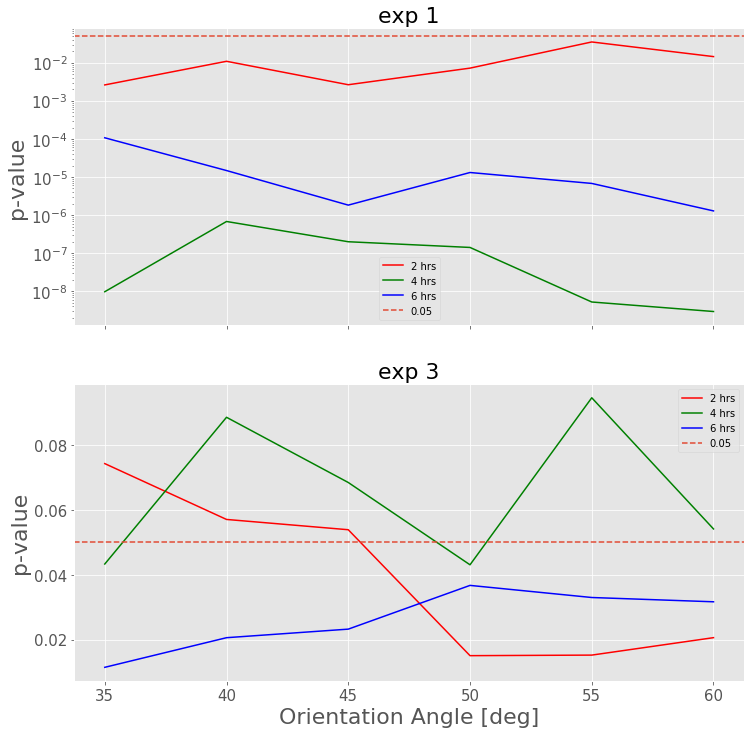

In [4]:
fig, axes = plt.subplots(2,1,figsize=(12,12), sharex=True)

ax = axes.ravel()

ax[0].plot(exp1_2hrs['Orientation Angle'], exp1_2hrs['p_value'],
           "r",
           label='2 hrs'
          )
ax[0].plot(exp1_4hrs['Orientation Angle'], exp1_4hrs['p_value'],
           "g",
           label='4 hrs'
          )
ax[0].plot(exp1_6hrs['Orientation Angle'], exp1_6hrs['p_value'],
           "b",
           label='6 hrs'
          )

ax[0].set_yscale('log')
ax[0].set_title('exp 1')
ax[0].set_xticks(np.arange(35, 65, 5))
ax[0].set_ylabel('p-value')
ax[0].axhline(0.05, ls="--", label='0.05')
ax[0].legend()

ax[1].plot(exp3_2hrs['Orientation Angle'],exp3_2hrs['p_value'],
           "r",
           label='2 hrs'
          )
ax[1].plot(exp3_4hrs['Orientation Angle'], exp3_4hrs['p_value'],
           "g",
           label='4 hrs'
          )
ax[1].plot(exp3_6hrs['Orientation Angle'], exp3_6hrs['p_value'],
           "b",
           label='6 hrs'
          )

ax[1].set_yscale('linear')
ax[1].set_title('exp 3')
ax[1].set_xticks(np.arange(35, 65, 5))
ax[1].set_xlabel('Orientation Angle [deg]')
ax[1].set_ylabel('p-value')
ax[1].axhline(0.05, ls="--", label='0.05')
ax[1].legend()

plt.savefig('{}p_values_vs_angles.png'.format(plots_dir))